In [833]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from fitter import Fitter
from scipy import signal
from pandas.plotting import autocorrelation_plot
from pmdarima.arima import ADFTest
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
sns.set_style('darkgrid')
# import arviz as az
# import pymc3 as pm
# from theano import tensor as tt
# from fitter import Fitter, get_common_distributions, get_distributions
# import mean_squared_error
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# from sklearn.metrics import accuracy_score,confusion_matrix
# from pandas.plotting import lag_plot
# from pmdarima.arima import auto_arima
%matplotlib inline
# import shap

In [834]:
os.chdir('G:/My Drive/To_Do/MMM/Raw_Hain_Data/Pivot')

In [871]:
# smd_pivot = pd.read_csv('smd_pivot.csv')
# ts_pivot = pd.read_csv('ts_pivot.csv')
# ct = pd.read_csv('ct_spend.csv') # need information on revenue or impressions
dm_pivot = pd.read_csv('smd_pivot.csv')

In [872]:
df = dm_pivot
print(df.head())

         DATE  CustomerEvent_I  CustomerEvent_S  DigitalCoupon_I  \
0  2021-02-01              NaN              NaN          48000.0   
1  2021-02-08              NaN              NaN              NaN   
2  2021-02-15              NaN              NaN              NaN   
3  2021-02-22              NaN              NaN              NaN   
4  2021-03-01              NaN              NaN              NaN   

   DigitalCoupon_S  DigitalDemo_I  Digital_Demo_S  Digital_Incentive_I  \
0              0.0            NaN             NaN                  NaN   
1              NaN            NaN             NaN                  NaN   
2              NaN            NaN             NaN                  NaN   
3              NaN            NaN             NaN                  NaN   
4              NaN            NaN             NaN           20701810.0   

   Digital_Incentive_S  Digital_Media_I  ...  Retailer_Media_S  Sampling_I  \
0                  NaN         100000.0  ...               NaN      

In [837]:
def missing_values(df):
    names = [var for var in df.columns]
    missing_count = df[names].isnull().sum()
    var_count = np.array(df[names].isnull().sum() * 100/ len(df)).round(2)
    missing = pd.DataFrame(index=names)
    missing["Count Missing"] = missing_count
    missing["Percent Missing"] = var_count
    print(missing)

In [838]:
def dickey_fuller(df):
    adf_test = ADFTest(alpha = .05)
    print('Because the ADF is smaller than the given alpha, the null hypothesis is false,'
          'and it is most likely not stationery.')
    result = adf_test.should_diff(df['revenue'])
    return result

In [839]:
def unique(df):
    percent_unique = np.array(100 * df.nunique()/len(df.index)).round(2)
    count_unique = df.nunique()
    names = [var for var in df.columns]
    unique_df = pd.DataFrame(index=names)
    unique_df["Count Unique"] = count_unique
    unique_df["Percent Unique"] = percent_unique
    print(unique_df)

In [870]:
def corr_plot(df):
    corr_temp = df.drop(['DATE'], axis=1)
    corr_names = corr_temp.columns.tolist()
    temp_df = df[corr_names]
    corr = temp_df.corr(method="spearman").round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(18, 18))
    cmap = sns.diverging_palette(250, 1, as_cmap=True)
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap,
                vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [874]:
def summary(df):
    print(missing_values(df))
    print(unique(df))
    corr_plot(df)

                     Count Missing  Percent Missing
DATE                             0             0.00
CustomerEvent_I                110            99.10
CustomerEvent_S                110            99.10
DigitalCoupon_I                 98            88.29
DigitalCoupon_S                 98            88.29
DigitalDemo_I                  110            99.10
Digital_Demo_S                 110            99.10
Digital_Incentive_I            107            96.40
Digital_Incentive_S            107            96.40
Digital_Media_I                102            91.89
Digital_Media_S                102            91.89
Direct_Mail_I                  110            99.10
Direct_Mail_S                  110            99.10
Email_Blast_I                  107            96.40
Email_Blast_S                  107            96.40
IRC_I                          108            97.30
IRC_S                          108            97.30
LCM_I                          104            93.69
LCM_S       

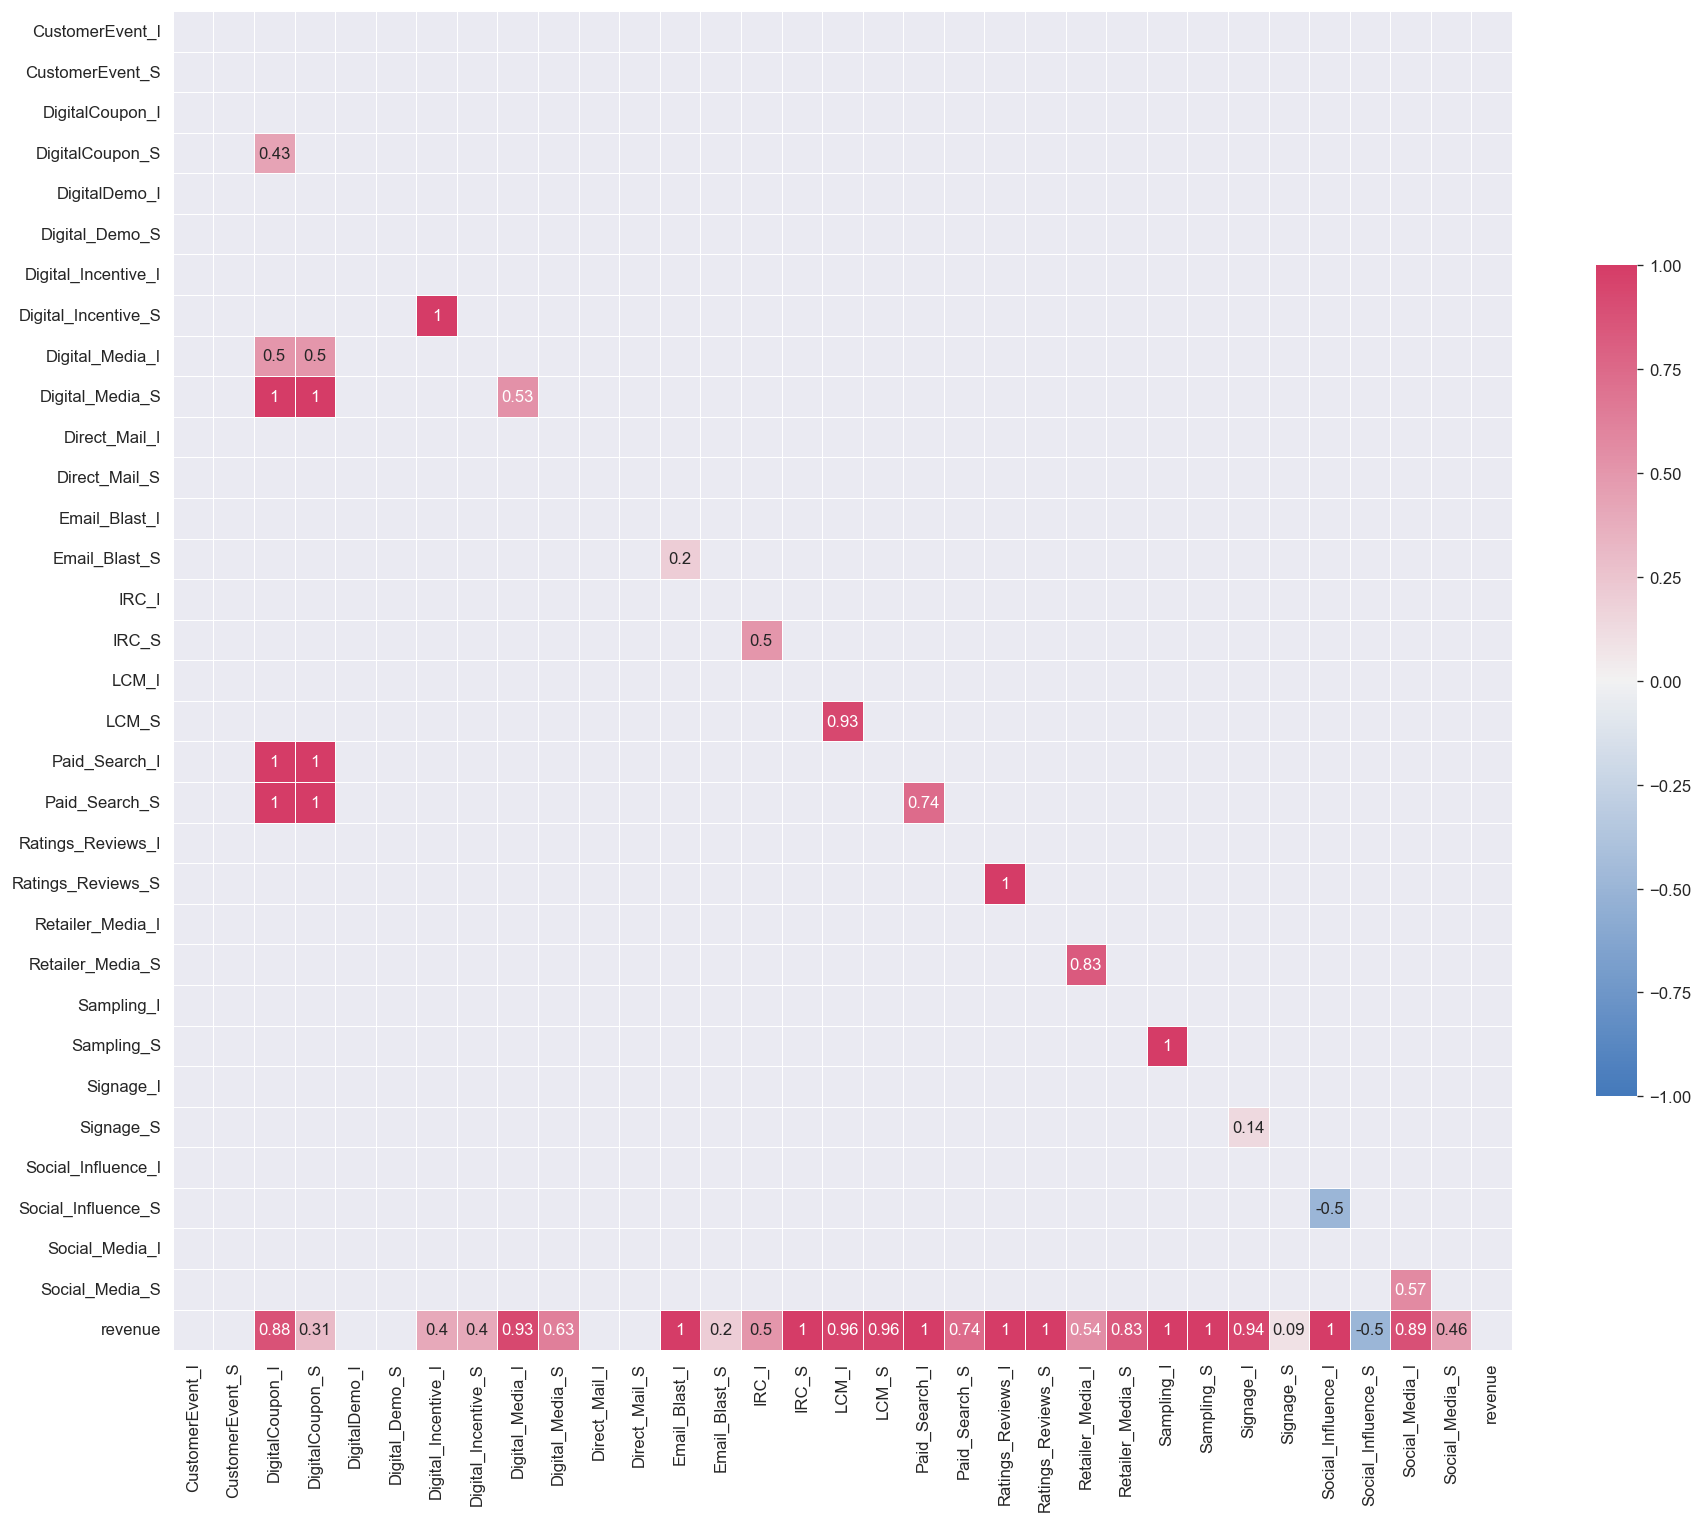

In [875]:
summary(df)

                     Count Missing  Percent Missing
DATE                             0             0.00
CustomerEvent_I                110            99.10
CustomerEvent_S                110            99.10
DigitalCoupon_I                 98            88.29
DigitalCoupon_S                 98            88.29
DigitalDemo_I                  110            99.10
Digital_Demo_S                 110            99.10
Digital_Incentive_I            107            96.40
Digital_Incentive_S            107            96.40
Digital_Media_I                102            91.89
Digital_Media_S                102            91.89
Direct_Mail_I                  110            99.10
Direct_Mail_S                  110            99.10
Email_Blast_I                  107            96.40
Email_Blast_S                  107            96.40
IRC_I                          108            97.30
IRC_S                          108            97.30
LCM_I                          104            93.69
LCM_S       

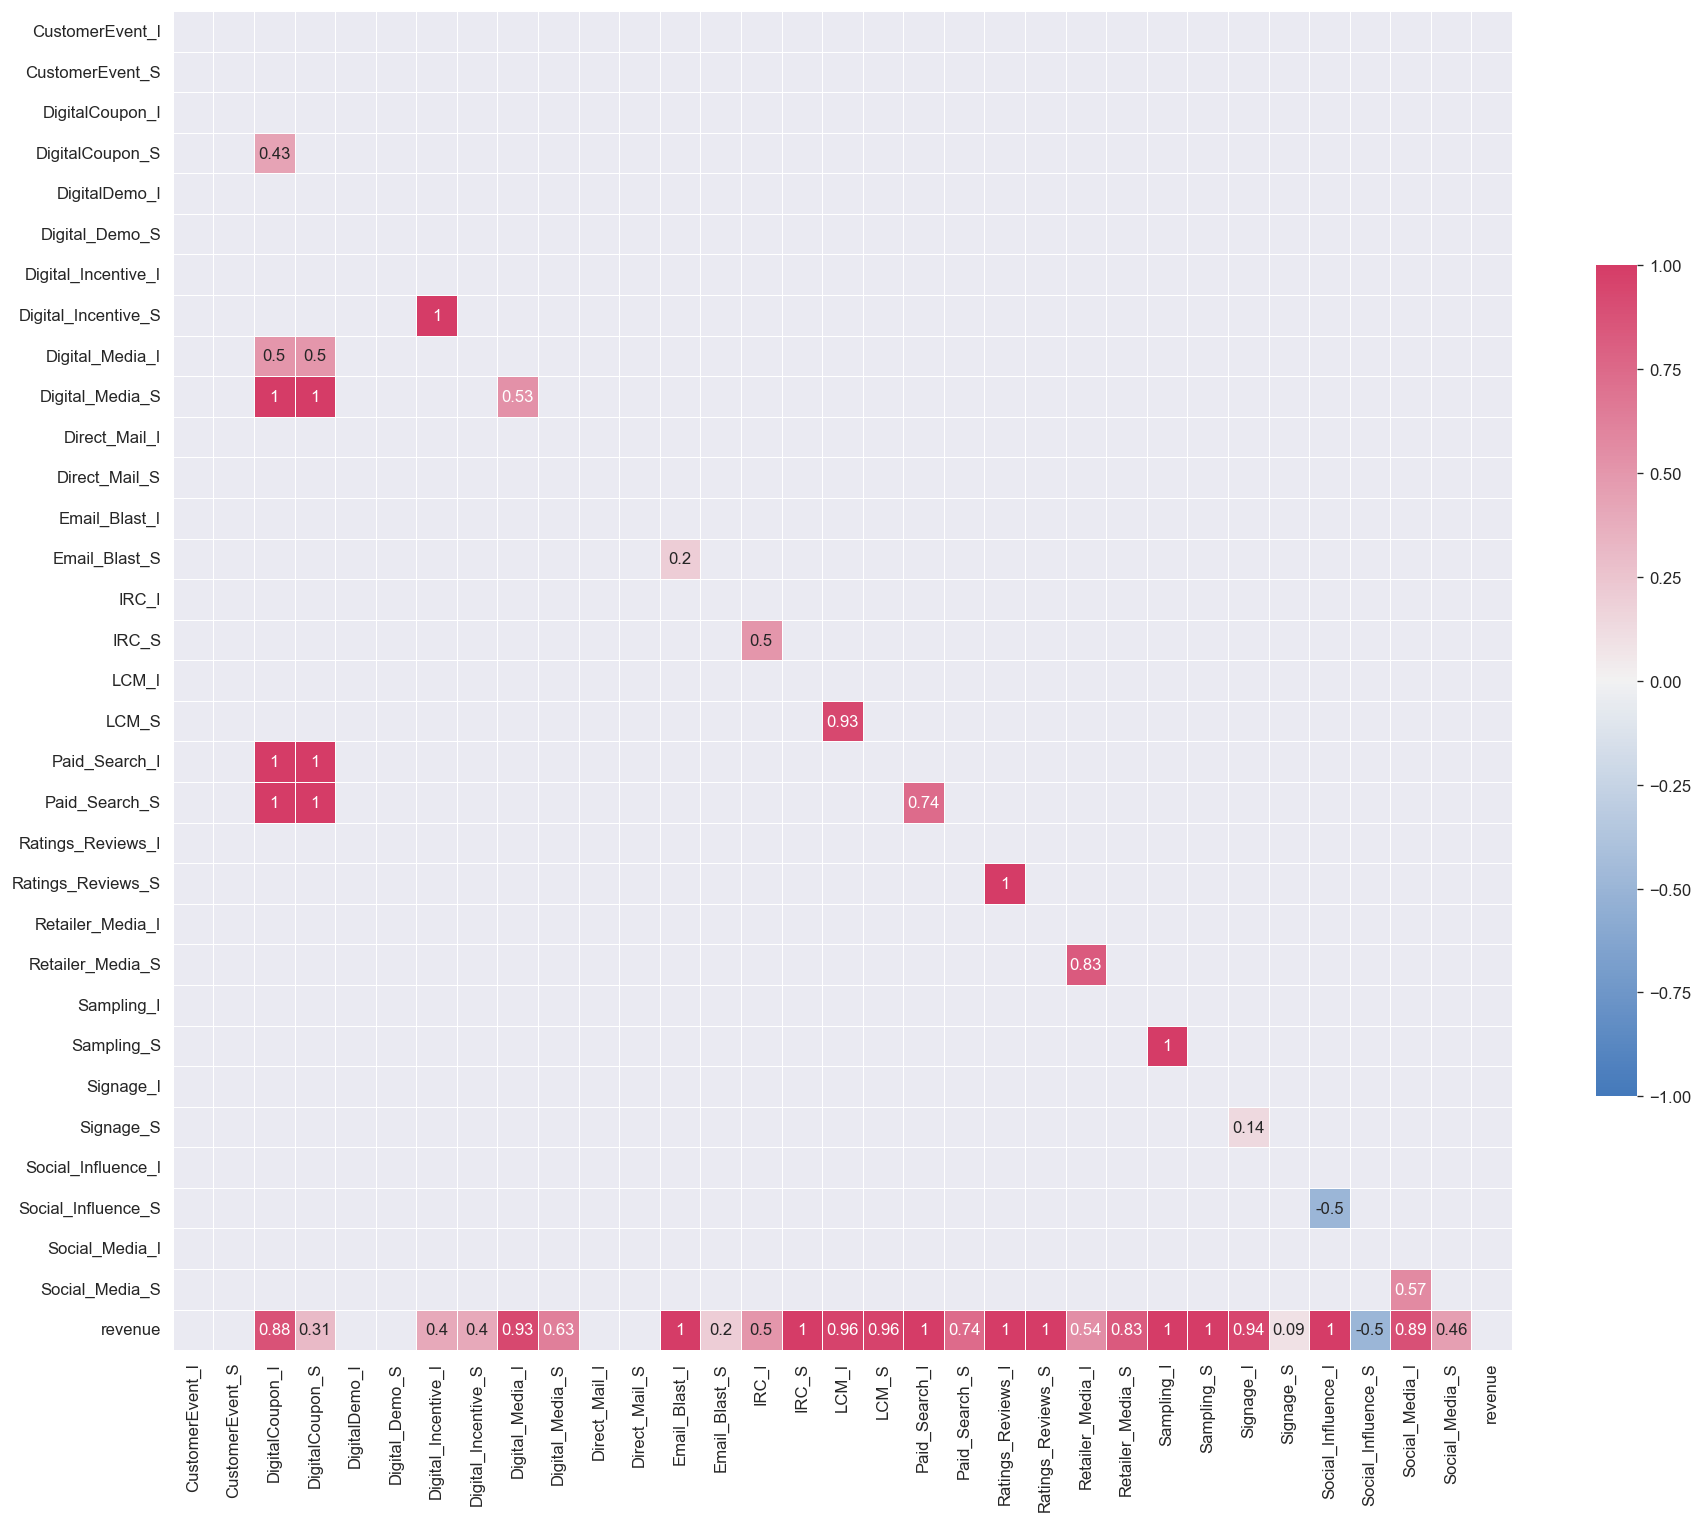

In [876]:
temp_week = df['DATE']
corr_temp = df.drop(['DATE'], axis=1)
corr_names = corr_temp.columns.tolist()
df = df.drop([], axis=1)
summary(df)

Explain the decisions to drop

Understand what the numbers mean and at which level their dangerous,

look through parameter options

Selecting from the most likely distributions of the data,
finds the most likely distribution for the data, its parameters,
and is useful for any data transformations. Discover the best
interpretation of the distributions.

Get the best interpretation of the data and the plot

Validate whether or not the data is autocorrelated

Figure out how to unscale the KNN data

In [ ]:
# # KNN Imputation
# df_knn = temp_df.filter(['onlinedisplay_S', 'onlinedisplay_I', 'onlinevideo_S',
#                     'onlinevideo_I', 'paidsearch_S', 'paidsearch_I', 'social_S',
#                     'social_I', 'revenue'], axis=1).copy()

In [ ]:
# # Define scaler to set values between 0 and 1
# scaler = MinMaxScaler(feature_range=(0, 1))
# df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)
# # Define KNN imputer and fill missing values
# knn_imputer = KNNImputer(n_neighbors=12, weights='distance', metric='nan_euclidean')
# df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

In [859]:
df = df.drop(columns='DATE')
imputer = KNNImputer(n_neighbors=10, weights='distance', metric='nan_euclidean')
imputed_KNN = imputer.fit_transform(df)
imputed_KNN = pd.DataFrame(imputed_KNN, columns = df.columns)
KNN_imputation = pd.concat([imputed_KNN, temp_week], axis=1)

Mice is the most robust imputation method, but it still leaves some zeros in the data that need to be fixed for Robyn.

In [867]:
mice_names = tuple(corr_names)
mice_temp = df[corr_names]
df_mice = mice_temp.filter(mice_names, axis=1).copy()

mice_estimator = IterativeImputer(estimator=linear_model.BayesianRidge(), sample_posterior=True, max_iter=40,
                                n_nearest_features=10, imputation_order='random', min_value=500)

In [868]:
df_mice_imputed = pd.DataFrame(mice_estimator.fit_transform(df_mice), columns=df_mice.columns)
imputed_mice = pd.concat([df_mice_imputed, temp_week], axis=1)

In [869]:
imputed_mice.to_csv('smd_mice_1.csv', encoding='utf-8', index=False)
KNN_imputation.to_csv('smd_KNN_1.csv', encoding='utf-8', index=False)

Read through shap documentation, figure out how to better visualize and analyze data

In [847]:
detrended = signal.detrend(df['revenue'].values)
plt.rcParams.update({'figure.figsize': (18,6)})
plt.plot(detrended)
plt.title('Sales Detrended', fontsize=16)

ValueError: array must not contain infs or NaNs

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

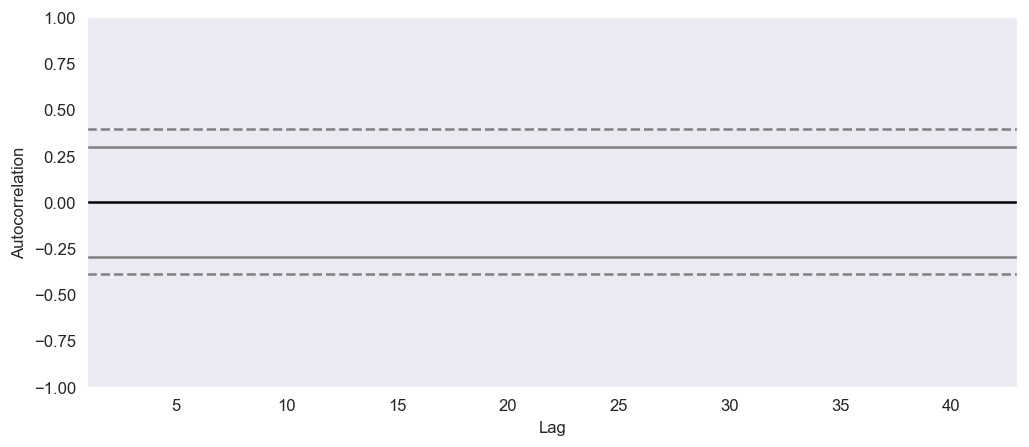

In [848]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(df['revenue'].tolist())

In [846]:
dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in temp_df:
    dist_test = temp_df[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 98.04it/s]


onlinedisplay_S
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
gamma       2.285326e-07  2201.283462 -648.976686     inf      0.116201   
norm        2.303676e-07  2248.079335 -652.252117     inf      0.121941   
cauchy      2.512839e-07  2240.227358 -649.210368     inf      0.138419   
expon       2.534437e-07  2183.428244 -648.910830     inf      0.219546   
uniform     2.670785e-07  2098.282318 -647.076794     inf      0.395226   

         ks_pvalue  
gamma     0.688888  
norm      0.631343  
cauchy    0.472085  
expon     0.058188  
uniform   0.000019  
{'gamma': {'a': 3.662580304641777, 'loc': -2631.462320962549, 'scale': 3787.4639707628417}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 47.38it/s]


onlinedisplay_I
         sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon       9.991350e-12  3211.733378 -1003.852036     inf      0.142333   
gamma       1.002383e-11  3217.401653 -1000.183078     inf      0.148514   
norm        1.112137e-11  3210.205395 -1000.101818     inf      0.174274   
uniform     1.117097e-11  3128.425817  -999.946066     inf      0.284675   
cauchy      1.140295e-11  3277.028736  -999.226697     inf      0.217829   

         ks_pvalue  
expon     0.437134  
gamma     0.384972  
norm      0.211904  
uniform   0.005286  
cauchy    0.061451  
{'expon': {'loc': 1.0, 'scale': 1971869.2857142857}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 63.68it/s]


onlinevideo_S
         sumsquare_error            aic         bic  kl_div  ks_statistic  \
cauchy      7.654117e-07    2250.399918 -480.957172     inf      0.218941   
norm        9.876013e-07    2114.205547 -473.820948     inf      0.222592   
expon       1.058292e-06    2088.526534 -471.885233     inf      0.332890   
uniform     1.091332e-06    2005.551495 -471.024445     inf      0.409609   
gamma       1.294274e-06  629804.893593 -462.916809     inf      0.964286   

            ks_pvalue  
cauchy   1.169047e-01  
norm     1.064120e-01  
expon    2.875871e-03  
uniform  9.211351e-05  
gamma    6.033997e-41  
{'cauchy': {'loc': 5397.909981738163, 'scale': 1348.271988085708}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 41.65it/s]


onlinevideo_I
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
cauchy      5.473559e-11  3165.151518 -748.235513     inf      0.203510   
norm        6.020679e-11  3083.461081 -745.567925     inf      0.170412   
expon       6.710796e-11  3047.197026 -742.529435     inf      0.359701   
uniform     6.757794e-11  2969.654232 -742.334023     inf      0.373827   
gamma       8.077045e-11          inf -734.008592     NaN      0.785714   

            ks_pvalue  
cauchy   1.709260e-01  
norm     3.500654e-01  
expon    9.461132e-04  
uniform  5.067080e-04  
gamma    7.040254e-19  
{'cauchy': {'loc': 743491.8670321961, 'scale': 223391.62759039406}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 52.90it/s]


paidsearch_S
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
uniform         0.000005  1816.252030 -461.775541     inf      0.216173   
expon           0.000005  1877.717918 -460.441233     inf      0.197998   
gamma           0.000005  1855.347986 -456.264169     inf      0.236039   
norm            0.000005  1853.317753 -459.661289     inf      0.237493   
cauchy          0.000005  1916.443042 -458.635400     inf      0.177867   

         ks_pvalue  
uniform   0.103826  
expon     0.166004  
gamma     0.059228  
norm      0.056731  
cauchy    0.265635  
{'uniform': {'loc': 939.0, 'scale': 8615.0}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 53.46it/s]


paidsearch_I
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
uniform     3.031168e-08  2347.325041 -614.585509     inf      0.202247   
expon       3.173537e-08  2408.795756 -613.208550     inf      0.217325   
gamma       3.233512e-08  2388.586669 -609.245687     inf      0.241533   
norm        3.233531e-08  2386.595587 -612.646704     inf      0.241713   
cauchy      3.322010e-08  2449.135271 -611.836849     inf      0.197368   

         ks_pvalue  
uniform   0.149320  
expon     0.100641  
gamma     0.050258  
norm      0.049985  
cauchy    0.168599  
{'uniform': {'loc': 18516.0, 'scale': 122593.0}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 54.64it/s]


social_S
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
gamma       8.299001e-08  2437.388792 -663.671727     inf      0.198496   
expon       9.007361e-08  2385.709858 -664.413249     inf      0.280714   
cauchy      9.795686e-08  2514.987338 -661.560651     inf      0.293592   
uniform     1.013792e-07  2289.146451 -660.393067     inf      0.390211   
norm        1.017440e-07  2373.818765 -660.270948     inf      0.231778   

         ks_pvalue  
gamma     0.119332  
expon     0.007315  
cauchy    0.004313  
uniform   0.000036  
norm      0.043422  
{'gamma': {'a': 0.6950464474022588, 'loc': 983.9999999999998, 'scale': 29408.64759327699}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 47.84it/s]


social_I
         sumsquare_error          aic          bic  kl_div  ks_statistic  \
gamma       2.518966e-12  3600.025572 -1017.361047     inf      0.286278   
expon       2.702085e-12  3451.539680 -1018.501451     inf      0.312617   
cauchy      2.962117e-12  3572.529424 -1015.377515     inf      0.307978   
uniform     3.023191e-12  3351.347936 -1014.683620     inf      0.385677   
norm        3.026425e-12  3436.537475 -1014.647268     inf      0.212568   

         ks_pvalue  
gamma     0.005840  
expon     0.001886  
cauchy    0.002320  
uniform   0.000046  
norm      0.079361  
{'gamma': {'a': 0.9023268461212842, 'loc': 79079.99999999999, 'scale': 3279511.854811252}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 45.24it/s]

revenue
         sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon       3.961822e-13  3552.623236 -1182.987504     inf      0.214921   
gamma       3.975402e-13  3547.283239 -1179.249980     inf      0.225880   
cauchy      4.468778e-13  3689.184452 -1178.532304     inf      0.280994   
norm        4.835274e-13  3543.419842 -1175.615862     inf      0.241102   
uniform     4.853269e-13  3456.160352 -1175.478418     inf      0.394092   

         ks_pvalue  
expon     0.055864  
gamma     0.038555  
cauchy    0.004465  
norm      0.022319  
uniform   0.000011  
{'expon': {'loc': 0.0, 'scale': 9142247.45945946}}


<AxesSubplot: xlabel='revenue', ylabel='Density'>

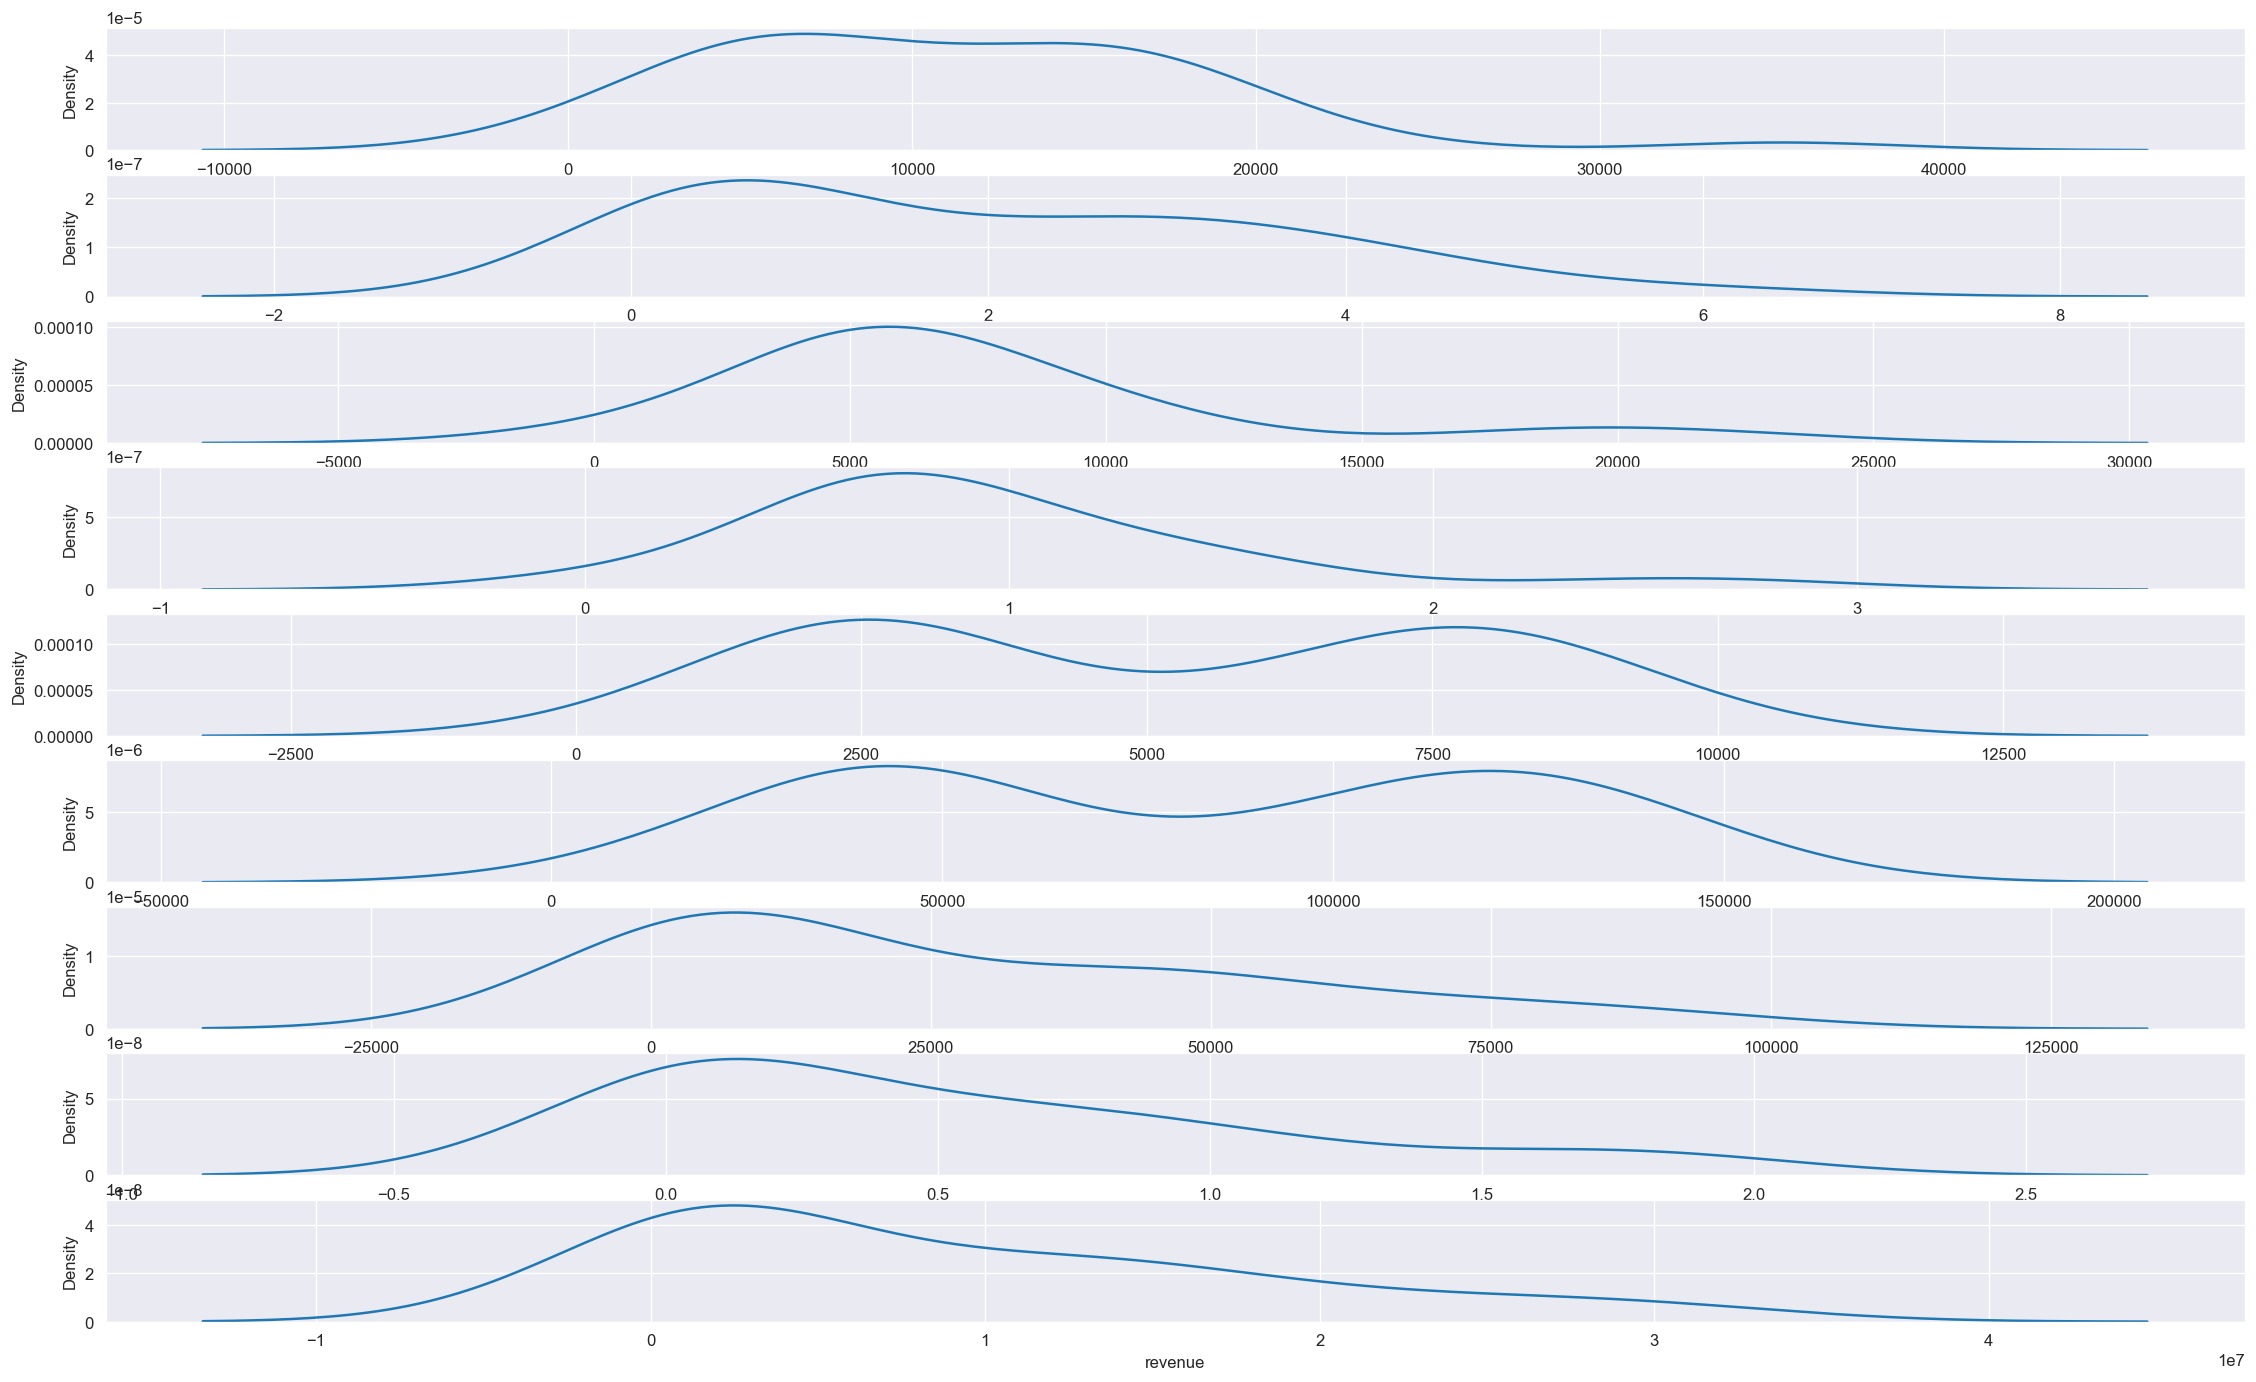

In [845]:
figure, axes = plt.subplots(9, 1, figsize=(23, 14))
sns.kdeplot(ax=axes[0], x='onlinedisplay_S', data=df)
sns.kdeplot(ax=axes[1], x='onlinedisplay_I', data=df)
sns.kdeplot(ax=axes[2], x='onlinevideo_S', data=df)
sns.kdeplot(ax=axes[3], x='onlinevideo_I', data=df)
sns.kdeplot(ax=axes[4], x='paidsearch_S', data=df)
sns.kdeplot(ax=axes[5], x='paidsearch_I', data=df)
sns.kdeplot(ax=axes[6], x='social_S', data=df)
sns.kdeplot(ax=axes[7], x='social_I', data=df)
sns.kdeplot(ax=axes[8], x='revenue', data=df)